# U-net
https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification

In [1]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, RepeatVector, Reshape
from keras.layers.normalization import BatchNormalization

from tqdm import tqdm_notebook
from ipywidgets import IntProgress

import warnings
warnings.simplefilter("ignore", UserWarning)

Using TensorFlow backend.


## Params and helpers

In [2]:
img_size_ori = 101
img_size_target = 128
n_features = 1

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

## Loading of training/testing ids and depths

In [6]:
train_df = pd.read_csv("../../tgs_data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../../tgs_data/depths.csv", index_col="id")

# standardize depths
depths_mean = np.mean(depths_df['z'].values)
depths_std = np.std(depths_df['z'].values)
depths_df['z'] = (depths_df['z'] - depths_mean) / depths_std

train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

## Load the images and masks into the DataFrame and divide the pixel values by 255
If run into "IntProgress not defined" error, run jupyter nbextension enable --py --sys-prefix widgetsnbextension in command line.

In [7]:
train_df["images"] = [np.array(load_img("../../tgs_data/train/images/{}.png".format(idx), grayscale=True)) / 
                      255 for idx in tqdm_notebook(train_df.index)];

In [8]:
train_df["masks"] = [np.array(load_img("../../tgs_data/train/masks/{}.png".format(idx), grayscale=True)) / 
                     255 for idx in tqdm_notebook(train_df.index)];

In [9]:
test_df["images"] = [np.array(load_img("../../tgs_data/test/{}.png".format(idx), grayscale=True)) / 
                     255 for idx in tqdm_notebook(test_df.index)];

/Users/fanliu/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Calculating the salt coverage and salt coverage classes

In [10]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

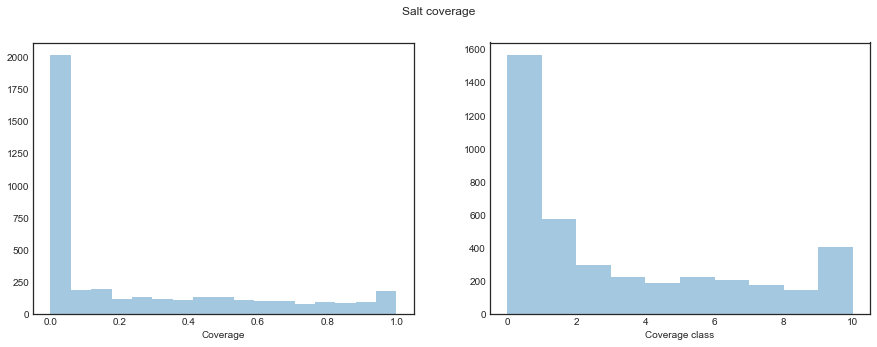

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

## Create train/validation split stratified by salt coverage

In [12]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_valid, depth_train, depth_valid = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337);

In [13]:
# create extra features
x_feat_train = depth_train.T
x_feat_valid = depth_valid.T

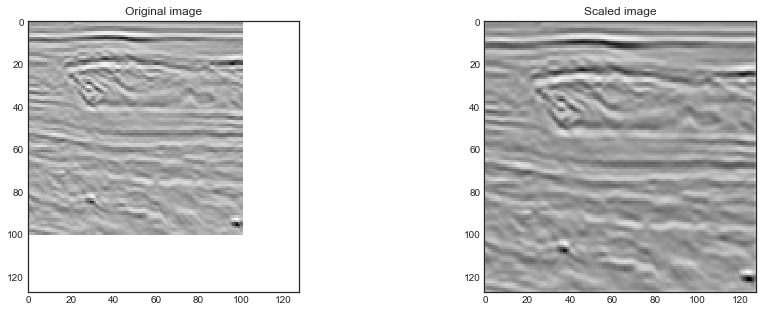

In [14]:
idx = 9

tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[idx]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[idx]]

fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[idx].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

## Build model

In [15]:
# def build_model(input_layer, input_features, start_neurons):
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Join features information in the deepest layer
    #f_repeat = RepeatVector(8*8)(input_features)
    #f_conv = Reshape((8, 8, n_features))(f_repeat)
    #pool4_feat = concatenate([pool4, f_conv], -1)
    
    # Middle
    #convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4_feat)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    convm = BatchNormalization()(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    
    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    
    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
#input_features = Input((n_features, ), name='feat')
output_layer = build_model(input_layer, 2)
#output_layer = build_model(input_layer, input_features, 2)

In [17]:
model = Model(inputs=input_layer, outputs=output_layer)
#model = Model(inputs=[input_layer, input_features], outputs=output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_39 (Conv2D)               (None, 128, 128, 2)   20          input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_40 (Conv2D)               (None, 128, 128, 2)   38          conv2d_39[0][0]                  
____________________________________________________________________________________________________
batch_normalization_11 (BatchNor (None, 128, 128, 2)   8           conv2d_40[0][0]                  
___________________________________________________________________________________________

## Data augmentation

In [18]:
# For training set
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
#x_train = np.append(x_train, [np.rot90(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(y) for y in y_train], axis=0)
#y_train = np.append(y_train, [np.rot90(y) for y in y_train], axis=0)

# Copy the depth 3 more times as well
#x_feat_train = np.repeat(x_feat_train, 4, axis=0)

## Train model

In [19]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=0)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 100
batch_size = 10

#history = model.fit([x_train, x_feat_train], y_train,
history = model.fit(x_train, y_train,
                    #validation_data=[[x_valid, x_feat_valid], y_valid],
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Train on 6400 samples, validate on 800 samples
Epoch 1/100
6400/6400 [==============================] - 254s - loss: 0.5757 - acc: 0.7424 - val_loss: 0.6187 - val_acc: 0.7468
Epoch 2/100
6400/6400 [==============================] - 244s - loss: 0.5053 - acc: 0.7485 - val_loss: 0.5436 - val_acc: 0.7468
Epoch 3/100
6400/6400 [==============================] - 253s - loss: 0.4611 - acc: 0.7710 - val_loss: 0.6500 - val_acc: 0.4746
Epoch 4/100
6400/6400 [==============================] - 250s - loss: 0.4327 - acc: 0.8004 - val_loss: 0.5655 - val_acc: 0.6637
Epoch 5/100
6400/6400 [==============================] - 247s - loss: 0.4251 - acc: 0.8062 - val_loss: 0.8056 - val_acc: 0.4339
Epoch 6/100
 280/6400 [>.............................] - ETA: 232s - loss: 0.3948 - acc: 0.8373

KeyboardInterrupt: 

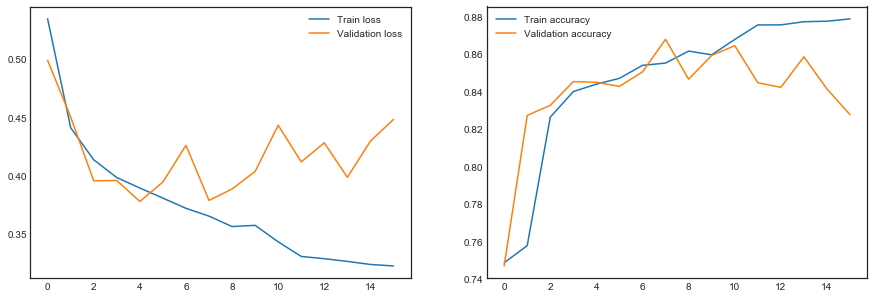

In [17]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.legend()

In [17]:
model = load_model("./keras.model")

## Predict the validation set to do a sanity check

In [18]:
#preds_valid = model.predict([x_valid, x_feat_valid]).reshape(-1, img_size_target, img_size_target)
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid = np.array([downsample(x) for x in y_valid])

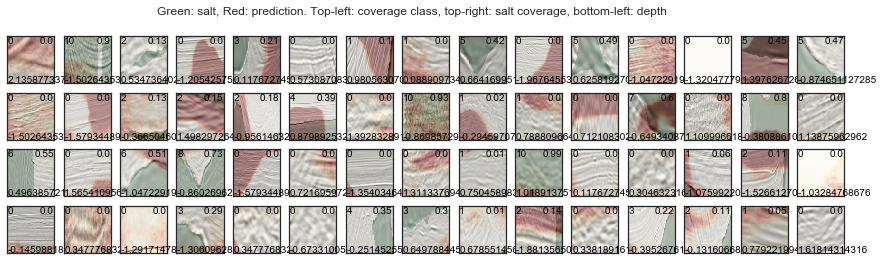

In [19]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_train[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

## Score the model and do a threshold optimization by the best IoU

In [20]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [21]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [22]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

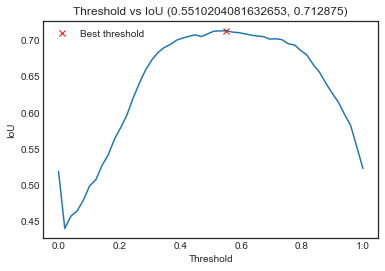

In [23]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

## Another sanity check with adjusted threshold

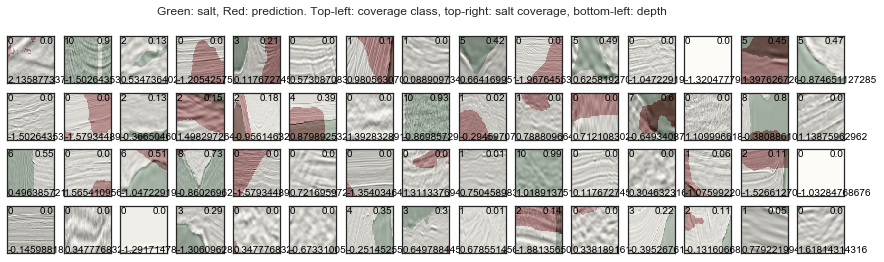

In [24]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_train[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

## Prepare for submission

In [25]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [26]:
x_test = np.array(test_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
depths_test = test_df.z.values

In [27]:
#x_test = np.array([upsample(np.array(load_img("../../tgs_data/test/{}.png".format(idx), grayscale=True))) 
#                   / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [28]:
preds_test = model.predict(x_test)
#preds_test = model.predict([x_test, depths_test])

In [32]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) 
             for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [33]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('../submissions/submission_08_01.csv')